In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
def sigmoid(Z):
    A= 1/(1+np.exp(-Z))
    cache= Z
    return A, cache

In [3]:
def relu(Z):
    A= Z*(Z>0)
    cache= Z
    return A, cache

In [4]:
def sigmoid_derivative(Z):
    f, g= sigmoid(Z)
    return f*(1-f)

In [5]:
def relu_derivative(Z):
    Z[Z<=0] = 0
    Z[Z>0] = 1
    return Z

In [6]:
def sigmoid_backward(dA, activation_cache):
    Z= activation_cache
    return dA*sigmoid_derivative(Z)

In [7]:
def relu_backward(dA, activation_cache):
    Z= activation_cache
    return dA*relu_derivative(Z)

In [8]:
data= 'titanic_train.csv'
test_data="titanic_test.csv"

In [9]:
X= pd.read_csv(data, index_col='PassengerId')
X_test=pd.read_csv(test_data, index_col="PassengerId")
Y= X.Survived
X=X.drop(['Survived'], axis=1)
print(X.head())

             Pclass                                               Name  \
PassengerId                                                              
1                 3                            Braund, Mr. Owen Harris   
2                 1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
3                 3                             Heikkinen, Miss. Laina   
4                 1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
5                 3                           Allen, Mr. William Henry   

                Sex   Age  SibSp  Parch            Ticket     Fare Cabin  \
PassengerId                                                                
1              male  22.0      1      0         A/5 21171   7.2500   NaN   
2            female  38.0      1      0          PC 17599  71.2833   C85   
3            female  26.0      0      0  STON/O2. 3101282   7.9250   NaN   
4            female  35.0      1      0            113803  53.1000  C123   
5              male  35.0

In [10]:
# Get names of columns with missing values
cols_with_missing = [col for col in X.columns if X[col].isnull().any()]
print("cols with missing: ",cols_with_missing)
object_cols = [col for col in X.columns if X[col].dtype == "object"]
print("object cols: ",object_cols)
object_nunique = list(map(lambda col: X[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))
print("no. of unique entries: ", d)
low_cardinality_cols = [col for col in object_cols if X[col].nunique() < 10]
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))
print("low_cardinality_cols: ",low_cardinality_cols)
print("high_cardinality_cols: ", high_cardinality_cols)
numerical_cols= list(set(X.columns)-set(object_cols))
print("numerical_cols", numerical_cols)

cols with missing:  ['Age', 'Cabin', 'Embarked']
object cols:  ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
no. of unique entries:  {'Name': 891, 'Sex': 2, 'Ticket': 681, 'Cabin': 147, 'Embarked': 3}
low_cardinality_cols:  ['Sex', 'Embarked']
high_cardinality_cols:  ['Ticket', 'Cabin', 'Name']
numerical_cols ['SibSp', 'Parch', 'Pclass', 'Age', 'Fare']


In [11]:
X= X.drop(high_cardinality_cols, axis=1)
X_test= X_test.drop(high_cardinality_cols, axis=1)

In [12]:
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[ ('imputer', SimpleImputer(strategy='most_frequent')),
                                           ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols),
                                                 ('cat', categorical_transformer, low_cardinality_cols)])

In [13]:
X_transformed= preprocessor.fit_transform(X)
X_transformed= pd.DataFrame(StandardScaler().fit_transform(X_transformed))
X_transformed.index= X.index
print(X)
print(X_transformed)

             Pclass     Sex   Age  SibSp  Parch     Fare Embarked
PassengerId                                                      
1                 3    male  22.0      1      0   7.2500        S
2                 1  female  38.0      1      0  71.2833        C
3                 3  female  26.0      0      0   7.9250        S
4                 1  female  35.0      1      0  53.1000        S
5                 3    male  35.0      0      0   8.0500        S
...             ...     ...   ...    ...    ...      ...      ...
887               2    male  27.0      0      0  13.0000        S
888               1  female  19.0      0      0  30.0000        S
889               3  female   NaN      1      2  23.4500        S
890               1    male  26.0      0      0  30.0000        C
891               3    male  32.0      0      0   7.7500        Q

[891 rows x 7 columns]
                    0         1         2             3         4         5  \
PassengerId                            

In [14]:
X_test_trans= preprocessor.fit_transform(X_test)
X_test_trans= pd.DataFrame(StandardScaler().fit_transform(X_test_trans))
X_test_trans.index= X_test.index
print(X_test)
print(X_test_trans)

             Pclass     Sex   Age  SibSp  Parch      Fare Embarked
PassengerId                                                       
892               3    male  34.5      0      0    7.8292        Q
893               3  female  47.0      1      0    7.0000        S
894               2    male  62.0      0      0    9.6875        Q
895               3    male  27.0      0      0    8.6625        S
896               3  female  22.0      1      1   12.2875        S
...             ...     ...   ...    ...    ...       ...      ...
1305              3    male   NaN      0      0    8.0500        S
1306              1  female  39.0      0      0  108.9000        C
1307              3    male  38.5      0      0    7.2500        S
1308              3    male   NaN      0      0    8.0500        S
1309              3    male   NaN      1      1   22.3583        C

[418 rows x 7 columns]
                    0         1         2             3         4         5  \
PassengerId               

In [15]:
X_train, X_val, Y_train, Y_val= train_test_split(X_transformed, Y, test_size=0.3, random_state= 1)
X_train=X_train.T
X_val= X_val.T
train_indices=Y_train.index
val_indices=Y_val.index
test_indices=X_test.index
Y_train= np.array([Y_train])
Y_val= np.array([Y_val])
X_test= X_test_trans.T
print(X_test.shape)

(10, 418)


In [16]:
X= X_transformed.T
Y=np.array([Y])
print(X.shape)
print(Y.shape)

(10, 891)
(1, 891)


In [17]:
# GRADED FUNCTION: initialize_parameters_deep

def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        ### END CODE HERE ###
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [18]:
# GRADED FUNCTION: linear_forward

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    Z = np.dot(W,A)+b
    ### END CODE HERE ###
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [19]:
# GRADED FUNCTION: linear_activation_forward

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        ### END CODE HERE ###
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

        ### END CODE HERE ###
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [20]:
# GRADED FUNCTION: L_model_forward

def L_model_forward(X, parameters,keep_prob):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    DD=[]
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        ### START CODE HERE ### (≈ 2 lines of code)
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation="relu")
        D = np.random.rand(A.shape[0],A.shape[1])                   # Step 1: initialize matrix D1 = np.random.rand(..., ...)
        D = (D < keep_prob).astype(int)               # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
        DD.append(D)
        A = np.multiply(A,D)                                         # Step 3: shut down some neurons of A1
        A = A/keep_prob  
        caches.append(cache)
        ### END CODE HERE ###
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    ### START CODE HERE ### (≈ 2 lines of code)
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation="sigmoid")
    caches.append(cache)
    ### END CODE HERE ###
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches, DD

In [21]:
# GRADED FUNCTION: compute_cost

def compute_cost(AL, Y, parameters):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]
    lambd=0.7
    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    cost = -sum(sum(np.multiply(Y,np.log(AL))+np.multiply(1-Y,np.log(1-AL))))/m 
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [22]:
# GRADED FUNCTION: compute_cost_with_regularization

def compute_cost_with_regularization(AL, Y, parameters, cost, lambd):

    m = Y.shape[1]
    
    ### START CODE HERE ### (approx. 1 line)
    reg=0
    for l in range(1,len(parameters)//2+1):
        reg=reg+np.sum(np.square(parameters['W'+str(l)]))
    L2_regularization_cost = lambd*reg/(2*m)
    ### END CODER HERE ###
    
    cost = cost+L2_regularization_cost
    
    return cost

In [23]:
# GRADED FUNCTION: linear_backward

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    ### START CODE HERE ### (≈ 3 lines of code)
    dW = np.dot(dZ,A_prev.T)/m  
    db = np.sum(dZ, axis=1, keepdims=True )/m
    dA_prev = np.dot(W.T,dZ)
    ### END CODE HERE ###
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [24]:
# GRADED FUNCTION: linear_activation_backward

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### END CODE HERE ###
        
    elif activation == "sigmoid":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### END CODE HERE ###
    
    return dA_prev, dW, db

In [25]:
# GRADED FUNCTION: L_model_backward

def L_model_backward(AL, Y, caches, DD, keep_prob):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    ### START CODE HERE ### (1 line of code)
    dAL =  -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    ### END CODE HERE ###
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    ### START CODE HERE ### (approx. 2 lines)
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation= "sigmoid")
    
    ### END CODE HERE ###
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        ### START CODE HERE ### (approx. 5 lines) 
        grads["dA" + str(l+1)]= grads["dA" + str(l+1)]*DD[l]/keep_prob
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation= "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        ### END CODE HERE ###

    return grads

In [26]:
# GRADED FUNCTION: backward_propagation_with_regularization

def backward_propagation_with_regularization(X, grads, lambd):

    m = X.shape[1]
    for l in range(1,len(grads)//3+1):
        grads["dW"+str(l)]=lambd*grads["dW"+str(l)]/m
    
    return grads

In [27]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] =  parameters["W" + str(l+1)] -learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] -learning_rate*grads["db" + str(l+1)]
    ### END CODE HERE ###
    return parameters

In [28]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate , num_iterations, keep_prob, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches, DD = L_model_forward(X, parameters, keep_prob)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y, parameters)
        #cost = compute_cost_with_regularization(AL, Y, parameters, cost, lambd)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches, DD, keep_prob)
        #grads = backward_propagation_with_regularization(X, grads, lambd)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [29]:
def predict (X,parameters):
    L=len(parameters)//2
    A=X
    for l in  range (1,L):
        Z= np.dot(parameters['W'+str(l)],A)+parameters['b'+str(l)]
        A,temp= relu(Z)
    Z= np.dot(parameters['W'+str(L)],A)+parameters['b'+str(L)]
    A,temp= sigmoid(Z)
    A=np.round(A)
    return(A)

In [30]:
### CONSTANTS ###
layers_dims = [10,6,6,6,1] 

Cost after iteration 0: 0.727956
Cost after iteration 100: 0.500910
Cost after iteration 200: 0.487355
Cost after iteration 300: 0.448952
Cost after iteration 400: 0.463147
Cost after iteration 500: 0.447075
Cost after iteration 600: 0.439473
Cost after iteration 700: 0.449445
Cost after iteration 800: 0.440021
Cost after iteration 900: 0.425448
Cost after iteration 1000: 0.441463
Cost after iteration 1100: 0.453338
Cost after iteration 1200: 0.404848
Cost after iteration 1300: 0.410778
Cost after iteration 1400: 0.436536
Cost after iteration 1500: 0.445800
Cost after iteration 1600: 0.444133
Cost after iteration 1700: 0.426333
Cost after iteration 1800: 0.426857
Cost after iteration 1900: 0.440438
Cost after iteration 2000: 0.427758
Cost after iteration 2100: 0.421690
Cost after iteration 2200: 0.428134
Cost after iteration 2300: 0.420440
Cost after iteration 2400: 0.432067


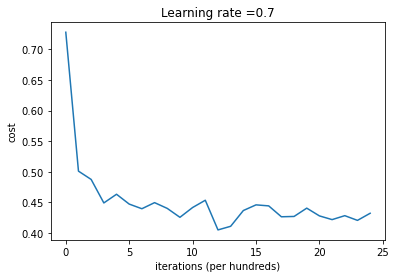

In [31]:
parameters = L_layer_model(X_train, Y_train,  layers_dims, learning_rate = 0.7, num_iterations = 2500, keep_prob=0.8 ,print_cost = True)

In [32]:
#val accuracydata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYgAAAEWCAYAAAB8LwAVAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjMsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+AADFEAAAgAElEQVR4nO3deZhcdZ3v8fen9/SWrTtJZyOhEyAhIGgTWdTBBQT1guOgAzoKzigyd7iOOo4X7njVgXEedWZ0nCszIyIoVxEQHI2AclFBBFnSYU8iEBIgTbZOOkln6/17/zinQ9FUJx2SSnVXfV7PU0/VOed3Tn1PV1KfOtvvKCIwMzMbqiTfBZiZ2ejkgDAzs6wcEGZmlpUDwszMsnJAmJlZVg4IMzPLygFhRU3SLyRdmO86zEYjB4TlhaTnJb0j33VExNkR8f181wEg6R5JHzsM71Mp6VpJnZI2SPrMftp/Om23PZ2vMmPalZKelNQn6Uu5rt0OLweEFSxJZfmuYdBoqgX4EjAfOAJ4K/A5SWdlayjpncBlwNuBOcCRwN9nNFkFfA64PXflWr44IGzUkfQeSY9J2ibp95KOz5h2maTnJO2QtELSH2dMu0jS/ZK+IakD+FI67j5J/yxpq6Q1ks7OmGfvr/YRtJ0r6d70vX8l6SpJPxhmHU6X1Cbpf0raAFwnaaKk2yS1p8u/TdLMtP2XgTcD35K0U9K30vHHSLpLUoekpyV94BD8iT8CXBkRWyNiJfAd4KJh2l4IfDcilkfEVuDKzLYR8f2I+AWw4xDUZaOMA8JGFUmvB64FPgFMBr4NLMnYrfEcyRfpeJJfsj+Q1JSxiDcCq4EpwJczxj0NNABfA74rScOUsK+2NwAPp3V9CfjwflZnGjCJ5Jf6xST/365Lh2cDe4BvAUTE3wG/Ay6NiNqIuFRSDXBX+r5TgAuAf5d0bLY3k/TvaahmezyRtpkITAcez5j1cSDrMtPxQ9tOlTR5P+tuBcABYaPNx4FvR8RDEdGfHh/oBk4GiIgfR8S6iBiIiJuAZ4HFGfOvi4j/ExF9EbEnHfdCRHwnIvqB7wNNwNRh3j9rW0mzgZOAL0RET0TcByzZz7oMAF+MiO6I2BMRWyLi1ojYHRE7SALsj/Yx/3uA5yPiunR9HgFuBc7L1jgi/ntETBjmMbgVVps+b8+YdTtQN0wNtVnaso/2VkAcEDbaHAH8TeavX2AWya9eJH0kY/fTNmARya/9QWuzLHPD4IuI2J2+rM3Sbl9tpwMdGeOGe69M7RHRNTggqVrStyW9IKkTuBeYIKl0mPmPAN445G/xIZItk9dqZ/pcnzGunuF3Ee3M0pZ9tLcC4oCw0WYt8OUhv36rI+JHko4g2V9+KTA5IiYATwGZu4ty1T3xemCSpOqMcbP2M8/QWv4GOBp4Y0TUA29Jx2uY9muB3w75W9RGxF9mezNJ/5kev8j2WA6QHkdYD7wuY9bXAcuHWYflWdpujIgtw6+2FQoHhOVTuaSqjEcZSQBcIumNStRIerekOqCG5Eu0HUDSR0m2IHIuIl4AWkkOfFdIOgX4bwe4mDqS4w7bJE0Cvjhk+kaSs4QG3QYcJenDksrTx0mSFgxT4yVpgGR7ZB5juB74fHrQ/BiS3XrfG6bm64G/kLQwPX7x+cy2aU1VJN8lZennONwWkY0xDgjLpztIvjAHH1+KiFaSL6xvAVtJTqO8CCAiVgD/AjxA8mV6HHD/Yaz3Q8ApwBbgH4CbSI6PjNS/AuOAzcCDwC+HTP8mcF56htO/pccpzgTOB9aR7P76KlDJwfkiycH+F4DfAv8UEb8EkDQ73eKYDZCO/xpwd9r+BV4ZbN8h+ewuAP4ufb2/g/c2Rsg3DDJ7bSTdBPwhIoZuCZgVBG9BmI1QununWVKJkgvLzgV+mu+6zHJlNF3daTbaTQN+QnIdRBvwlxHxaH5LMssd72IyM7OsvIvJzMyyKphdTA0NDTFnzpx8l2FmNqYsW7Zsc0Q0ZptWMAExZ84cWltb812GmdmYIumF4aZ5F5OZmWWV04CQdFbaRfEqSZdlmf6NtF+dxyQ9k/Y1MzjtQknPpg/f8cvM7DDL2S6m9HL7q4AzSE4JXCppSXo1LAAR8emM9v8DODF9PdgNQQtJ1wrL0nm35qpeMzN7pVxuQSwGVkXE6ojoAW4kubBoOBcAP0pfvxO4KyI60lC4C8h6xyszM8uNXAbEDF7ZHXJbOu5V0l465wK/OZB5JV0sqVVSa3t7+yEp2szMErkMiGx37BruqrzzgVvSm7SMeN6IuDoiWiKipbEx61laZmb2GuUyINp4ZX/5M0l6pMzmfF7evXSg85qZWQ7kMiCWAvOV3Oi9giQEXnWLRklHAxNJunAedCdwZtpf/USSLo/vzEWR23b38M1fPcuKdZ25WLyZ2ZiVs7OYIqJP0qUkX+ylwLURsVzSFUBrRAyGxQXAjZHRKVREdEi6kiRkAK6IiI5c1CnEt+5+ll09fSycXr//GczMikTBdNbX0tISr/VK6ouue5hVm3byu8+9FSnb4Q8zs8IkaVlEtGSb5iupgXctaqJt6x6WezeTmdleDgjgjIVTKS0Rdzy5Pt+lmJmNGg4IYGJNBac2T+aOJ9dTKLvczMwOlgMidfaiJp7fsps/bNiR71LMzEYFB0TqzGOnUiL4hXczmZkBDoi9GmorOfnIydzx1IZ8l2JmNio4IDKcfVwTqzbt5NmN3s1kZuaAyPDOY6ciwc2ta/ff2MyswDkgMkypq+KPT5jB9Q+8wPrte/JdjplZXjkghvj0GUcRAd+465l8l2JmllcOiCFmTarmw6ccwS3L2njGxyLMrIg5ILL4q7fOo6aijK/98ul8l2JmljcOiCwm1VRwyenN/GrlRh5ek5NOZM3MRj0HxDA+etocmsZX8akbH2VjZ1e+yzEzO+wcEMOorijjOx9pYdueXv78e0vZ1d2X75LMzA4rB8Q+LJoxnqs+9Hr+sGEHf3XDI/T1D+S7JDOzw8YBsR9vPXoK//DeRdzzdDuX3vAo2/f05rskM7PDwgExAhcsns3n372Au1Zu5F3f/B2tz/vAtZkVPgfECH3szUdyyyWnUFoiPvDtB/jy7SvYvLM732WZmeWMA+IAnDh7Ird/8k38yetncs19a3jTV3/Dl5Ys56Vt7pbDzAqPCuUOai0tLdHa2nrY3u+59p38xz3P8dNHX6I/glObJ/PHJ87krEXTqK0sO2x1mJkdDEnLIqIl6zQHxMFp27qbW5a18ZNHXuLFjt1UlZfwtmOm8J7jp/PWo6cwrqL0sNdkZjZSDojDICJY9sJWljy+jjueXM/mnT3UVZbxvtfP4EMnH8FRU+vyVpuZ2XDyFhCSzgK+CZQC10TEV7K0+QDwJSCAxyPig+n4fuDJtNmLEXHOvt4r3wGRqa9/gIfWdPDj1rXc8eQGevoHOOXIyfzduxewaMb4fJdnZrZXXgJCUinwDHAG0AYsBS6IiBUZbeYDNwNvi4itkqZExKZ02s6IqB3p+42mgMjUsauHH7eu5ep7V9Oxu4cPLp7NZ888mok1FfkuzcxsnwGRy7OYFgOrImJ1RPQANwLnDmnzceCqiNgKMBgOhWRSTQWf+KNmfvPZ07no1DncuHQtb//6b3ls7bZ8l2Zmtk+5DIgZQOa9O9vScZmOAo6SdL+kB9NdUoOqJLWm49+b7Q0kXZy2aW1vbz+01R9i48eV88X/diy3f/JN1FSW8qHvPMiDq7fkuywzs2HlMiCUZdzQ/VllwHzgdOAC4BpJE9Jps9PNng8C/yqp+VULi7g6IloioqWxsfHQVZ5Dx0yr58efOJWmCeO48NqHuefpgttoMrMCkcuAaANmZQzPBNZlafOziOiNiDXA0ySBQUSsS59XA/cAJ+aw1sNq2vgqbrr4ZOZNqeXj17fy1Evb812Smdmr5DIglgLzJc2VVAGcDywZ0uanwFsBJDWQ7HJaLWmipMqM8acBKyggk2sr+eHH3siE6gr+561PuKdYMxt1chYQEdEHXArcCawEbo6I5ZKukDR4yuqdwBZJK4C7gb+NiC3AAqBV0uPp+K9knv1UKCZUV3DluceyfF0n19y3Jt/lmJm9gi+UGwU+8X9buefpdn75qbcwt6Em3+WYWRHJ12muNkJXnLuIirISLv/JExRKYJvZ2OeAGAWm1ldx+dkLeHB1B79e6bOazGx0cECMEu9vmUljXSU/evjFfJdiZgY4IEaN8tISPtAyk7uf3sT67b6/hJnlnwNiFDn/pNkMBNy8tC3fpZiZOSBGk1mTqnnz/AZuWvoi/QM+WG1m+eWAGGU+uHg267Z3ce8zo7tvKTMrfA6IUebtC6bSUFvhg9VmlncOiFGmoqyE894wi1//YRMbO7vyXY6ZFTEHxCh03htm0j8Q/L8VG/NdipkVMQfEKNTcWMP08VU88NzmfJdiZkXMATEKSeLUeQ088NwWBnw2k5nliQNilDq1eTJbd/eyckNnvksxsyLlgBilTm1uAOD3q3xbUjPLDwfEKDVtfBVHNtbwex+HMLM8cUCMYqc1N/Dwmg56fbc5M8sDB8QodmrzZHb19PNE27Z8l2JmRcgBMYqdfORkJLjfxyHMLA8cEKPYxJoKFjbV+ziEmeWFA2KUO21eA4+8sI09Pf35LsXMiowDYpQ7pXkyPf0DtL7Qke9SzKzIOCBGuZYjJgLw2Is+UG1mh5cDYpSrqypnzuRqVqz3FdVmdnjlNCAknSXpaUmrJF02TJsPSFohabmkGzLGXyjp2fRxYS7rHO0WTq93QJjZYVeWqwVLKgWuAs4A2oClkpZExIqMNvOBy4HTImKrpCnp+EnAF4EWIIBl6bxbc1XvaLawqZ47ntzAjq5e6qrK812OmRWJXG5BLAZWRcTqiOgBbgTOHdLm48BVg1/8EbEpHf9O4K6I6Ein3QWclcNaR7WF0+sBWLl+R54rMbNiksuAmAGszRhuS8dlOgo4StL9kh6UdNYBzIukiyW1Smptby/cezgfO308ACvWbc9zJWZWTHIZEMoybujNDcqA+cDpwAXANZImjHBeIuLqiGiJiJbGxsaDLHf0mlJXyeSaCh+HMLPDKpcB0QbMyhieCazL0uZnEdEbEWuAp0kCYyTzFg1JPlBtZoddLgNiKTBf0lxJFcD5wJIhbX4KvBVAUgPJLqfVwJ3AmZImSpoInJmOK1oLm+p5ZsNO9+xqZodNzgIiIvqAS0m+2FcCN0fEcklXSDonbXYnsEXSCuBu4G8jYktEdABXkoTMUuCKdFzRWji9np7+AVZt2pnvUsysSOTsNFeAiLgDuGPIuC9kvA7gM+lj6LzXAtfmsr6x5Nj0TKYV6zpZ0FSf52rMrBj4SuoxYm5DLVXlJT4OYWaHjQNijCgtEUdPq2e5T3U1s8PEATGGLGyqZ8W6TpI9c2ZmueWAGEOOnV5PZ1cfL23bk+9SzKwIOCDGkIUZB6rNzHLNATGGHDOtDnCfTGZ2eDggxpDqijJmTBjHc+2+FsLMcs8BMcbMm1Lri+XM7LBwQIwx86bUsnrzTgYGfCaTmeWWA2KMaW6spat3wGcymVnOOSDGmHlTagFY5eMQZpZjDogxprmxBoDnfBzCzHLMATHGTK6tZGJ1uc9kMrOcc0CMQfOm1PLcpl35LsPMCpwDYgxqbqz1MQgzyzkHxBg0b0otHbt66NjVk+9SzKyAOSDGoOb0TCYfhzCzXHJAjEHzGtNTXX0mk5nlkANiDJoxYRxV5SU+1dXMcsoBMQaVlIgjG3yg2sxyywExRjW70z4zyzEHxBg1r7GWl7btYU9Pf75LMbMC5YAYo5qn1BABqzd7K8LMciOnASHpLElPS1ol6bIs0y+S1C7psfTxsYxp/Rnjl+SyzrFo3t5TXX1FtZnlRlmuFiypFLgKOANoA5ZKWhIRK4Y0vSkiLs2yiD0RcUKu6hvr5kyuoUQ+1dXMcmdEWxCS3j+ScUMsBlZFxOqI6AFuBM498BItm6ryUmZNqvaprmaWMyPdxXT5CMdlmgGszRhuS8cN9SeSnpB0i6RZGeOrJLVKelDSe7O9gaSL0zat7e3t+ymn8MxrrPXV1GaWM/vcxSTpbOBdwAxJ/5YxqR7o28+ylWXc0Ptk/hz4UUR0S7oE+D7wtnTa7IhYJ+lI4DeSnoyI516xsIirgasBWlpaiu4enPOm1PK7VZvpHwhKS7L9uc3MXrv9bUGsA1qBLmBZxmMJ8M79zNsGZG4RzEyXt1dEbImI7nTwO8AbMqatS59XA/cAJ+7n/YpO85RaevoGWNuxO9+lmFkB2ucWREQ8Djwu6YaI6AWQNBGYFRFb97PspcB8SXOBl4DzgQ9mNpDUFBHr08FzgJUZ77E73bJoAE4DvnZgq1b4mjP6ZJrTUJPnasys0Iz0LKa7JJ2Ttn8MaJf024j4zHAzRESfpEuBO4FS4NqIWC7pCqA1IpYAn0yX2wd0ABelsy8Avi1pgGQr5ytZzn4qepn3p34HU/NcjZkVmpEGxPiI6EyvU7guIr4o6Yn9zRQRdwB3DBn3hYzXl5PlYHdE/B44boS1Fa3x48pprKv0mUxmlhMjPYupTFIT8AHgthzWYweoubHGnfaZWU6MNCCuINlV9FxELE3PLHo2d2XZSM1LO+2LKLqTuMwsx0a0iykifgz8OGN4NfAnuSrKRm5eYy07uvpo39HNlPqqfJdjZgVkpFdSz5T0X5I2Sdoo6VZJM3NdnO3fvCl1AN7NZGaH3Eh3MV1Hcu3DdJKroX+ejrM8a56SnN7qA9VmdqiNNCAaI+K6iOhLH98DGnNYl43QtPoqaivL3GmfmR1yIw2IzZL+TFJp+vgzYEsuC7ORkeQzmcwsJ0YaEH9OcorrBmA9cB7w0VwVZQemubGW5zb5vhBmdmiNNCCuBC6MiMaImEISGF/KWVV2QJqn1LKhs4sdXb35LsXMCshIA+L4zL6XIqIDd543avjucmaWCyMNiJK0Az0AJE0ih3ejswOzt08mH6g2s0NopF/y/wL8XtItJPd0+ADw5ZxVZQdk9qRqykrkgDCzQ2qkV1JfL6mV5GY+At7n3lVHj/LSEo5srOGZjTvyXYqZFZAR7yZKA8GhMEotbKrnwdUd+S7DzArISI9B2Ci3cHo9Gzq76NjVk+9SzKxAOCAKxMKm8QCsXN+Z50rMrFA4IArEgqak074V6xwQZnZoOCAKxOTaSqbWV7LCWxBmdog4IArIwqZ672Iys0PGAVFAFk6vZ9WmnXT19ue7FDMrAA6IArKgqZ6+gfAFc2Z2SDggCsjCpnoAH4cws0PCAVFAjphcQ3VFqc9kMrNDIqcBIeksSU9LWiXpsizTL5LULumx9PGxjGkXSno2fVyYyzoLRWmJOHpanbcgzOyQyFmPrJJKgauAM4A2YKmkJVn6cLopIi4dMu8k4ItAC0nngMvSebdi+7SwqZ4lj68jIpCU73LMbAzL5RbEYmBVRKyOiB7gRuDcEc77TuCuiOhIQ+Eu4Kwc1VlQFk6vZ0dXH21b9+S7FDMb43IZEDOAtRnDbem4of5E0hOSbpE060DmlXSxpFZJre3t7Yeq7jHNB6rN7FDJZUBk278RQ4Z/DsyJiOOBXwHfP4B5iYirI6IlIloaGxsPqthCcfS0OiR3uWFmBy+XAdEGzMoYngmsy2wQEVsiojsd/A7whpHOa9lVV5Qxt6GG5eu257sUMxvjchkQS4H5kuZKqgDOB5ZkNpDUlDF4DrAyfX0ncKakiemtTs9Mx9kItBwxkdYXtjIw8KqNLjOzEctZQEREH3ApyRf7SuDmiFgu6QpJ56TNPilpuaTHgU8CF6XzdgBXkoTMUuCKdJyNwElzJrFtdy/P+opqMzsIOTvNFSAi7gDuGDLuCxmvLwcuH2bea4Frc1lfoXrj3MkAPPx8B0dPq8tzNWY2VvlK6gI0a9I4ptZX8vAab3SZ2WvngChAklg8dzIPr9lChI9DmNlr44AoUIvnTmJjZzdrO3zBnJm9Ng6IArV4ziQAHlqzJc+VmNlY5YAoUPOn1DKhupylz/s4hJm9Ng6IAlVSIlqOmOQD1Wb2mjkgCtgb507i+S272dTZle9SzGwMckAUsMVzk+MQD3s3k5m9Bg6IAnbs9HqqK0q9m8nMXhMHRAErKy2hZc4kfvfsZl8PYWYHzAFR4M5cOJU1m3fxzEb3y2RmB8YBUeDOPHYqEvziqfX5LsXMxhgHRIGbUlfFSUdM4pdPbch3KWY2xjggisBZi6bxhw07WLN5V75LMbMxxAFRBM5aNA3wbiYzOzAOiCIwfcI4XjdzvHczmdkBcUAUibMWNfFE23batu7OdylmNkY4IIrE2eluJm9FmNlIOSCKxJyGGo6ZVsftT/o4hJmNjAOiiJz3hpk8+uI2nnppe75LMbMxwAFRRN7fMovqilKuvX9NvksxszHAAVFExo8r57w3zOS2x9fTvqM73+WY2SjngCgyF546h57+AW546MV8l2Jmo1xOA0LSWZKelrRK0mX7aHeepJDUkg7PkbRH0mPp4z9zWWcxaW6s5fSjG/nBQy/Q0zeQ73LMbBTLWUBIKgWuAs4GFgIXSFqYpV0d8EngoSGTnouIE9LHJbmqsxh99LS5tO/o5vYn1+W7FDMbxXK5BbEYWBURqyOiB7gRODdLuyuBrwG+L+Zh8pb5DTQ31vDd+9b4PhFmNqxcBsQMYG3GcFs6bi9JJwKzIuK2LPPPlfSopN9KenO2N5B0saRWSa3t7e2HrPBCJ4lL/qiZp17q5OdP+LoIM8sulwGhLOP2/lyVVAJ8A/ibLO3WA7Mj4kTgM8ANkupftbCIqyOiJSJaGhsbD1HZxeF9r5/JgqZ6vvqLP9DV25/vcsxsFMplQLQBszKGZwKZO73rgEXAPZKeB04GlkhqiYjuiNgCEBHLgOeAo3JYa9EpLRGff/cCXtq2h+vufz7f5ZjZKJTLgFgKzJc0V1IFcD6wZHBiRGyPiIaImBMRc4AHgXMiolVSY3qQG0lHAvOB1TmstSidNq+BdyyYwlV3r2LzTl8XYWavlLOAiIg+4FLgTmAlcHNELJd0haRz9jP7W4AnJD0O3AJcEhEduaq1mF3+rgV09fbz9bueyXcpZjbKlOVy4RFxB3DHkHFfGKbt6RmvbwVuzWVtlmhurOXPTj6C7z/wPO85volTmxvyXZKZjRK+ktr423cezdyGGj5142Pe1WRmezkgjJrKMv7PBSeybU8vn/3x4wwM+NoIM3NAWOrY6eP5/LsXcM/T7Vxzn88HMDMHhGX48MlH8M5jp/LVXz7Nnct95zmzYueAsL0k8c/vfx3HzxzPpTc8wq9Xbsx3SWaWRw4Ie4W6qnK+99HFLGiq5y9/8Ai/fcZdmJgVKweEvcr4ceVc/+eLmTello9f38pPH30p3yWZWR44ICyrCdUV/PBjb+SEWRP41E2P8Y93rKTfZzeZFRUHhA1rYk0SEh855Qiuvnc1F133MJt2uFd2s2LhgLB9Ki8t4YpzF/GV9x3HQ2s6OOPr93LLsjbfR8KsCDggbETOXzybX/z1m5k/pZbP/vhxLrxuKas27cx3WWaWQw4IG7Hmxlpu/sQpXHHusSx7voN3/uu9XHbrE2zY7t1OZoVIhbKroKWlJVpbW/NdRtHYvLObb/1mFT986AVKJM4/aRYfe/ORzJpUne/SzOwASFoWES1Zpzkg7GCs7djNN3/9LD977CUGAt59XBMfe/Ncjp85Id+lmdkIOCAs59Zv38O1963hhodeZFdPPyfMmsBFp87h7OOmUVlWmu/yzGwYDgg7bDq7erl1WRvXP/ACazbvYkJ1Oee+bjrnvWEWi2bUI2W7VbmZ5YsDwg67gYHg/uc2c3NrG3cu30BP3wBHNtRw9nHTOHtRE8dOd1iYjQYOCMur7Xt6ue2Jddzx5HoeXN1B/0Awtb6S0+Y1cFpzA6c0T2b6hHH5LtOsKDkgbNTo2NXDr1Zs5LfPtvPAc1vo2NUDQNP4Kl5/xEReP3sir5s5nmOnj2dchY9dmOWaA8JGpYGBYOWGTpau6WDZi9tY9nwH69JrKkpLxLzGWhZOr2dBUx0LmupZ0FRPQ21lnqs2KywOCBszNnV28Xjbdp5o28ZTL21n5fodbOh8+UK8xrpKFjTVs7CpnoXTk+e5DTWUlvh4htlrsa+AKDvcxZjty5T6Ks5YWMUZC6fuHdexq4eV6zvTxw5WrO/ku8+tprc/+XFTXVHKwqZ6jp1ez7HTx7Nwej3zp9b69Fqzg+QtCBuTevoGWLVpJ8vXbWf5uk6Wr9vOinWd7OrpB6CsRBw1tY7jZ45n0YzxvG7mBI6eVkdFmXuXMcuUt11Mks4CvgmUAtdExFeGaXce8GPgpIhoTcddDvwF0A98MiLu3Nd7OSBsYCB4oWM3K9Z18tS67Tz10naefGk723b3AlBRVsKCpnqOnzGe42aO57gZ45k3pZbyUoeGFa+8BISkUuAZ4AygDVgKXBARK4a0qwNuByqASyOiVdJC4EfAYmA68CvgqIjoH+79HBCWTUTQtnUPj7dt44m27Ty2dhvLX9q+d0ujvFTMm1LHgqY6jp5ax1FT65g/tZYZE8b5Og0rCvk6BrEYWBURq9MibgTOBVYMaXcl8DXgsxnjzgVujIhuYI2kVenyHshhvVaAJDFrUjWzJlXznuOnA8mWxpotu/YeBF+5vpP7nt3MTx55+daq1RWlNDfWMm9KLXMbapg9qZrZk6uZPamayTUVDg8rCrkMiBnA2ozhNuCNmQ0knQjMiojbJH12yLwPDpl3Rq4KteJSUiKaG2tpbqzl3BNeHr9tdw/PbtrJMxt38OzGnTzXvpMHV2/hv4bck7uqvISZE6uZNXFc8jwpeZ45cRyzJlYzobrcAWIFIZcBke1/yN79WZJKgG8AFx3ovBnLuBi4GGD27NmvqUizQROqKzhpziROmjPpFeO7evtZ27GbF7bspm3rbtq27mFt+rzsha10dvW9on11RSnTJ4xLHuOrmFpfRdP4KqaOr6KxtpKG2kom11b42IeNerkMiDZgVsbwTGBdxnAdsAi4J/21NQ1YIumcEcwLQERcDVwNyTGIQ1m82aCq8lLmT61j/tS6rNO37+ndGxzJY7/oQUMAAAwfSURBVDfrt3WxbvseVqzrZMuubrId6ptQXb43MBrrKplSV8nU+iqm1CfDU+uraKitpL6qzFsklhe5DIilwHxJc4GXgPOBDw5OjIjtQMPgsKR7gM+mB6n3ADdI+jrJQer5wMM5rNXsNRs/rpzx45LuQbLp6Rtg044uNnZ2s3ln8mjfkb7e0UP7zm4eW7uNTTu66OodeNX8FWUlNNRU0FhXSWNdEiB7w6QuCZPBrRJf+2GHUs4CIiL6JF0K3Elymuu1EbFc0hVAa0Qs2ce8yyXdTHJAuw/4q32dwWQ2mlWUlaTHKPZ9t72IYEd3H5s6u9nU2cWmNETaM4KkbetuHnlx694+rIaqqyxjYk0Fk2oqmFxTwYTqCiZWlzOxpoLx48qZUF2eBlo59VXJc11VGWXe3WVZ+EI5szGop2+AzTu72djZxeadPenWSDdbdvXQkfHYtruHrbt72dO7799XNRWl1I8rp7ayjLqqMuqqkte1lWXUVJZRW1maPFel4yqS1zUVZdRUllJbWUZ1ZRnV5aWUuNuTMcVdbZgVmIqykr0Hwkeiq7efzj29bNvTy7bdvWzf8/JjR1cvnXv66OzqZWdXHzu6e9m6u4e1W3ezs6uPXd19e68bGYlx5UmY1FSWUl2RhEvy/PK4vc8VyfO4ilKqK0rT57LkdfnL46rKHDz54IAwKwJV5aVUlZcypb7qNc0/MBDs7u1nV3cfO7v79gbHzu4+dvX0sbO7nz09fezq7t8bKLt70nDp7t8bOLu7+9nV08funn76Bw5s70VlWcnesBhXUfqK4arykr3rWFVeQmXZ0NfJ9Mqy4Z8ry0qpLC/ZO66itKToQ8kBYWb7VVKivbucpu6/+X5FBN19A+zpeTkwdqehsqennz29/Vmfu3rT170DdPWmwz397OjupWvvuAG6+/rp7h2gp//VB/0PREVZycvhUVaSBshgoJSk09NgKU2mV5Qm4yvKSqgoLX35dVnSZvB1+eDr0hIqyrS3bXmp9o4fbFNemow/3GezOSDM7LCTtPcX/8Saipy9T/9A0N33ytDoSp+7+5JA6e4b2GebwWk9fS+P7+kfoLu3n86uPnr6eujpS5bT0zc4LXk+0K2k/anYGxh6OWRKS1g4vZ5vffD1h/S9wAFhZgWstETpMY38vH9ffxIUvX1Bd38/PX0D9PZHEiRpmLziuW+Anv7+V7TpG8icFvSmbXsHl90fzJqYm1v2OiDMzHKkrLQkOYW4AqA83+UcMJ/8bGZmWTkgzMwsKweEmZll5YAwM7OsHBBmZpaVA8LMzLJyQJiZWVYOCDMzy6pguvuW1A68cBCLaAA2H6JyxopiXGcozvUuxnWG4lzvA13nIyKiMduEggmIgyWpdbg+0QtVMa4zFOd6F+M6Q3Gu96FcZ+9iMjOzrBwQZmaWlQPiZVfnu4A8KMZ1huJc72JcZyjO9T5k6+xjEGZmlpW3IMzMLCsHhJmZZVX0ASHpLElPS1ol6bJ815MrkmZJulvSSknLJf11On6SpLskPZs+T8x3rYeapFJJj0q6LR2eK+mhdJ1vkpSn+43ljqQJkm6R9If0Mz+l0D9rSZ9O/20/JelHkqoK8bOWdK2kTZKeyhiX9bNV4t/S77cnJB3QfUmLOiAklQJXAWcDC4ELJC3Mb1U50wf8TUQsAE4G/ipd18uAX0fEfODX6XCh+WtgZcbwV4FvpOu8FfiLvFSVW98EfhkRxwCvI1n/gv2sJc0APgm0RMQioBQ4n8L8rL8HnDVk3HCf7dnA/PRxMfAfB/JGRR0QwGJgVUSsjoge4Ebg3DzXlBMRsT4iHklf7yD5wphBsr7fT5t9H3hvfirMDUkzgXcD16TDAt4G3JI2KcR1rgfeAnwXICJ6ImIbBf5Zk9xCeZykMqAaWE8BftYRcS/QMWT0cJ/tucD1kXgQmCCpaaTvVewBMQNYmzHclo4raJLmACcCDwFTI2I9JCECTMlfZTnxr8DngIF0eDKwLSL60uFC/MyPBNqB69Jda9dIqqGAP+uIeAn4Z+BFkmDYDiyj8D/rQcN9tgf1HVfsAaEs4wr6vF9JtcCtwKciojPf9eSSpPcAmyJiWeboLE0L7TMvA14P/EdEnAjsooB2J2WT7nM/F5gLTAdqSHavDFVon/X+HNS/92IPiDZgVsbwTGBdnmrJOUnlJOHww4j4STp64+AmZ/q8KV/15cBpwDmSnifZffg2ki2KCeluCCjMz7wNaIuIh9LhW0gCo5A/63cAayKiPSJ6gZ8Ap1L4n/Wg4T7bg/qOK/aAWArMT890qCA5qLUkzzXlRLrv/bvAyoj4esakJcCF6esLgZ8d7tpyJSIuj4iZETGH5LP9TUR8CLgbOC9tVlDrDBARG4C1ko5OR70dWEEBf9Yku5ZOllSd/lsfXOeC/qwzDPfZLgE+kp7NdDKwfXBX1EgU/ZXUkt5F8quyFLg2Ir6c55JyQtKbgN8BT/Ly/vj/RXIc4mZgNsl/svdHxNADYGOepNOBz0bEeyQdSbJFMQl4FPiziOjOZ32HmqQTSA7MVwCrgY+S/CAs2M9a0t8Df0pyxt6jwMdI9rcX1Gct6UfA6STdem8Evgj8lCyfbRqW3yI562k38NGIaB3xexV7QJiZWXbFvovJzMyG4YAwM7OsHBBmZpaVA8LMzLJyQJiZWVYOCDusJP0+fZ4j6YOHeNn/K9t75Yqk90r6Qo6WvTNHyz19sFfbg1jG9ySdt4/pl0r66MG8h40ODgg7rCLi1PTlHOCAAiLtfXdfXhEQGe+VK58D/v1gFzKC9cq5jKuND4VrSXpWtTHOAWGHVcYv468Ab5b0WNqPf6mkf5K0NO23/hNp+9OV3MfiBpKL/JD0U0nL0r7/L07HfYWkJ8/HJP0w873Sq0j/Kb1PwJOS/jRj2ffo5fsm/DC9sAhJX5G0Iq3ln7Osx1FAd0RsToe/J+k/Jf1O0jNpP1CD96IY0XpleY8vS3pc0oOSpma8z3kZbXZmLG+4dTkrHXcf8L6Meb8k6WpJ/w+4fh+1StK30r/H7WR08pft7xQRu4HnJS0eyb8JG70O5a8GswNxGemVzQDpF/32iDhJUiVwf/rFBUm37IsiYk06/OfpVaLjgKWSbo2IyyRdGhEnZHmv9wEnkNwXoSGd59502onAsST909wPnCZpBfDHwDEREZImZFnmacAjQ8bNAf4IaAbuljQP+MgBrFemGuDBiPg7SV8DPg78Q5Z2mbKtSyvwHZJ+qFYBNw2Z5w3AmyJizz4+gxOBo4HjgKkkXVhcK2nSPv5OrcCbgYf3U7ONYt6CsNHiTJI+Yx4j6f5jMslNTgAeHvIl+klJjwMPknRENp99exPwo4joj4iNwG+BkzKW3RYRA8BjJF/ynUAXcI2k95F0UTBUE0mX2plujoiBiHiWpHuLYw5wvTL1AIPHCpalde1PtnU5hqQTu2cj6TbhB0PmWRIRe9LXw9X6Fl7++60DfpO239ffaRNJr6o2hnkLwkYLAf8jIu58xcikD6VdQ4bfAZwSEbsl3QNUjWDZw8nsl6cfKIuIvnT3yNtJOvm7lOQXeKY9wPgh44b2WxOMcL2y6I2X+8Hp5+X/q32kP+zSXUiZt9B81boMU1emzBqGq/Vd2Zaxn79TFcnfyMYwb0FYvuwA6jKG7wT+UkmX5Eg6SslNboYaD2xNw+EYktunDuodnH+Ie4E/TfexN5L8Ih5214eSe2aMj4g7gE+R7J4aaiUwb8i490sqkdRMctOepw9gvUbqeZLdQpDc/yDb+mb6AzA3rQnggn20Ha7We4Hz079fE/DWdPq+/k5HAU9hY5q3ICxfngD60l1F3yO5h/Ic4JH0l3E72W8P+UvgEklPkHwBP5gx7WrgCUmPpN16D/ov4BTgcZJfwp+LiA1pwGRTB/xMUhXJr+pPZ2lzL/AvkpTxS/9pkt1XU4FLIqJL0jUjXK+R+k5a28Mk9x7e11YIaQ0XA7dL2gzcBywapvlwtf4XyZbBk8Az6TrCvv9OpwF/f8BrZ6OKe3M1e40kfRP4eUT8StL3gNsi4pb9zFbwJJ0IfCYiPpzvWuzgeBeT2Wv3j0B1vosYhRqA/53vIuzgeQvCzMyy8haEmZll5YAwM7OsHBBmZpaVA8LMzLJyQJiZWVb/HwhNrpHWw9gyAAAAAElFTkSuQmCC
pred= predict(X_train, parameters)
accuracy= 1-mean_absolute_error(pred,Y_train)
print(accuracy)

0.8603531300160514


In [33]:
pred= predict(X_val,parameters)
accuracy= 1-mean_absolute_error(pred,Y_val)
print(accuracy)

0.7723880597014925


In [34]:
pred= predict(X_test, parameters)
pred=pred.T
pred=pred.reshape(-1)
pred=pred.astype(int)
print(pred.shape)

(418,)


In [35]:
# Save test predictions to file
output = pd.DataFrame({'PassengerId': test_indices,
                       'Survived': pred})
output.to_csv('submission.csv', index=False)